# Superposed Epoch Analysis CMIP6 Historical model runs
- opens all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas
- calculates monthly anomalies (based on 5-yr climatology) for 4 spatial regions (global, SH, Aus, E Aus) and 5 eruptions
- calculates percentiles (10, 90) to show model spread
- superposes the time-series for 5 eruptions plus mmm for tas and pr and different regions (superposed epoch analysis)

In [3]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import seaborn as sns
import dask.diagnostics # dask allows you to check how long something is taking to load

In [4]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [5]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [6]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


In [7]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [8]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [9]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [10]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [11]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  
## Select out regions and eruption dates

In [13]:
# area weighting 
models_w = models*np.cos(models.lat*(np.pi/180))

In [14]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
# e_pre3mon = ['1883-05','1902-7', '1962-12', '1982-01', '1991-03']
# e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']

In [15]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [16]:
print(e_pre5yrs[1], e_pre3mon[0], e_post5yrs)

1897-10-01 00:00:00 1883-05-01 00:00:00 DatetimeIndex(['1888-09-01', '1907-11-01', '1968-04-01', '1987-05-01',
               '1996-07-01'],
              dtype='datetime64[ns]', freq=None)


In [17]:
# eruption names
volcanoes = ['Krakatau', 'Santa Maria','Agung','El Chichon', 'Pinatubo']

In [18]:
# select out hte 10 year time frame around each eruption (5yrs before and after)
# tas
Krakatau = models_w.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria = models_w.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung = models_w.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon = models_w.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo = models_w.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

## Anomalies 

In [19]:
# use functions to calculate the monthly anomalies for the globe
K_mon_anom_Glob = func.monthly_anomaly(Krakatau, e_pre5yrs[0], e_pre3mon[0])
S_mon_anom_Glob = func.monthly_anomaly(SantaMaria, e_pre5yrs[1], e_pre3mon[1])
A_mon_anom_Glob = func.monthly_anomaly(Agung, e_pre5yrs[2], e_pre3mon[2])
E_mon_anom_Glob = func.monthly_anomaly(ElChicon, e_pre5yrs[3], e_pre3mon[3])
P_mon_anom_Glob = func.monthly_anomaly(Pinatubo, e_pre5yrs[4], e_pre3mon[4])

In [20]:
# store all eruptions in one array
composite_mon_Glob = func.reset_time(K_mon_anom_Glob, S_mon_anom_Glob, A_mon_anom_Glob, E_mon_anom_Glob, P_mon_anom_Glob, volcanoes)

In [21]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

In [22]:
# select out each region
composite_mon_SH = composite_mon_Glob.sel(lat=slice(-90,0))
composite_mon_Aus = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
composite_mon_EA = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

## Multi-model mean and percentiles

In [23]:
# calculate the monthly model mean for monthly anomalies
composite_mmm_Glob = composite_mon_Glob.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_SH = composite_mon_SH.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_Aus = composite_mon_Aus.mean(dim='model').mean(dim=('lat','lon'))
composite_mmm_EA = composite_mon_EA.mean(dim='model').mean(dim=('lat','lon'))

In [24]:
# calcuate the lat lon mean (llm)
composite_llm_Glob = composite_mon_Glob.mean(dim=('lat','lon'))
composite_llm_SH = composite_mon_SH.mean(dim=('lat','lon'))
composite_llm_Aus = composite_mon_Aus.mean(dim=('lat','lon'))
composite_llm_EA = composite_mon_EA.mean(dim=('lat','lon'))

In [25]:
# calculate percentile
# 10th percentile
p10_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])

# 90th percentile
p90_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])

In [26]:
# take the composite over all volcanoes
V_composite_mmm_Glob = composite_mmm_Glob.mean(dim='volcano')
V_composite_mmm_SH = composite_mmm_SH.mean(dim='volcano')
V_composite_mmm_Aus = composite_mmm_Aus.mean(dim='volcano')
V_composite_mmm_EA = composite_mmm_EA.mean(dim='volcano')

In [27]:
# calculate standard deviation
std_Glob = func.std_bounds_MV(composite_llm_Glob, V_composite_mmm_Glob)
std_SH = func.std_bounds_MV(composite_llm_SH, V_composite_mmm_SH)
std_Aus = func.std_bounds_MV(composite_llm_Aus, V_composite_mmm_Aus)
std_EA = func.std_bounds_MV(composite_llm_EA, V_composite_mmm_EA)

In [ ]:
# calculate the minimum value of the mmm for each spatial region
min_mmm_Glob = min(V_composite_mmm_Glob)
min_mmm_SH = min(V_composite_mmm_SH)
min_mmm_Aus = min(V_composite_mmm_Aus)
min_mmm_EA = min(V_composite_mmm_EA)

# Figures

In [28]:
blues = sns.color_palette("Blues_r")
greens = sns.color_palette("Greens_r")
reds = sns.color_palette("Reds_r")

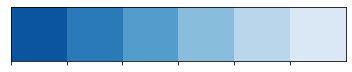

In [29]:
sns.palplot(sns.color_palette("Blues_r"))

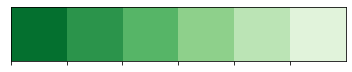

In [30]:
sns.palplot(sns.color_palette("Greens_r"))

In [31]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [ ]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.tas, V_composite_mmm_Glob.tas, p10_Glob.tas, p90_Glob.tas, reds, ax = axes[0,0])
func2.SEA_plots(composite_mmm_SH.tas, V_composite_mmm_SH.tas, p10_SH.tas, p90_SH.tas, reds, ax = axes[0,1])
func2.SEA_plots(composite_mmm_Aus.tas, V_composite_mmm_Aus.tas, p10_Aus.tas, p90_Aus.tas, reds, ax = axes[1,0])
func2.SEA_plots(composite_mmm_EA.tas, V_composite_mmm_EA.tas, p10_EA.tas, p90_EA.tas, reds, ax = axes[1,1])

# set axis labels and subplot titles
axes[0,0].set(ylabel = f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

fig.suptitle('Superposed epoch analysis of temperature anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('SEA_mon_tas.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot monthly anomalies of precipitation as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.pr, V_composite_mmm_Glob.pr, p10_Glob.pr, p90_Glob.pr, greens, ax = axes[0,0])
func2.SEA_plots(composite_mmm_SH.pr, V_composite_mmm_SH.pr, p10_SH.pr, p90_SH.pr, greens, ax = axes[0,1])
func2.SEA_plots(composite_mmm_Aus.pr, V_composite_mmm_Aus.pr, p10_Aus.pr, p90_Aus.pr, greens, ax = axes[1,0])
func2.SEA_plots(composite_mmm_EA.pr, V_composite_mmm_EA.pr, p10_EA.pr, p90_EA.pr, greens, ax = axes[1,1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0,0].set(ylabel = 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel = 'Precipitation anomaly [mm/day]', xlabel = 'Month relative to eruption', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

fig.suptitle('Superposed epoch analysis of precipitation anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('SEA_mon_pr.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot monthly anomalies of precipitation as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.pr, V_composite_mmm_Glob.pr, p10_Glob.pr, p90_Glob.pr, greens, ax = axes[0,0])
func2.SEA_plots(composite_mmm_SH.pr, V_composite_mmm_SH.pr, p10_SH.pr, p90_SH.pr, greens, ax = axes[0,1])
func2.SEA_plots(composite_mmm_Aus.pr, V_composite_mmm_Aus.pr, p10_Aus.pr, p90_Aus.pr, greens, ax = axes[1,0])
func2.SEA_plots(composite_mmm_EA.pr, V_composite_mmm_EA.pr, p10_EA.pr, p90_EA.pr, greens, ax = axes[1,1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0,0].set(ylabel = 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel = 'Precipitation anomaly [mm/day]', xlabel = 'Month relative to eruption', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

fig.suptitle('Superposed epoch analysis of precipitation anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('SEA_mon_pr.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.tas, V_composite_mmm_Glob.tas, p10_Glob.tas, p90_Glob.tas, reds, ax = axes[0])
func2.SEA_plots(composite_mmm_Aus.tas, V_composite_mmm_Aus.tas, p10_Aus.tas, p90_Aus.tas, reds, ax = axes[1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Australia')

fig.suptitle('Superposed epoch analysis of temperature anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('SEA_Glob&Aus_tas.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot monthly anomalies of precipitation as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

# make subplots for each region
func2.SEA_plots(composite_mmm_Glob.pr, V_composite_mmm_Glob.pr, p10_Glob.pr, p90_Glob.pr, greens, ax = axes[0])
func2.SEA_plots(composite_mmm_Aus.pr, V_composite_mmm_Aus.pr, p10_Aus.pr, p90_Aus.pr, greens, ax = axes[1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0].set(xlabel = 'Month relative to eruption', ylabel = 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = 'Precipitation anomaly [mm/day]', title = 'Australia')

fig.suptitle('Superposed epoch analysis of precipitation anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('SEA_Glob&Aus_pr.png', dpi=300, bbox_inches='tight')